In [223]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import config
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pdb
import os 
import sys
import pdb

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from collections import defaultdict
import datetime
import pdb
from dataset_characterization import dataset_characterization
import matplotlib.gridspec as gridspec


In [3]:
dates =  dataset_characterization.get_good_days()

In [151]:
channel_tunings = []
dates_used = []
for date in dates:
    file = os.path.join(config.preprocessingdir,f'{date}_preprocess.pkl')

    with open(file, 'rb') as f:
        data_CO, data_RD = pickle.load(f)

    if data_CO:
        dates_used.append(date)
        sbp = data_CO['sbp']
        kin = data_CO['finger_kinematics']
        trials = data_CO['trial_index']
        trial_len = data_CO['trial_count']
        tpos = data_CO['target_positions']
    else:
        continue

    channel_tuning = np.zeros((96,4))
    for i in np.arange(sbp.shape[1]):
        single_channel = sbp[:,i]
        for j in np.arange(kin.shape[1]):
            channel_tuning[i,j] = np.corrcoef(single_channel, kin[:,j])[0,1]
    
    channel_tunings.append(channel_tuning)

C:\Users\Hisham\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Hisham\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [152]:
len(pd.to_datetime(dates_used))

214

(214,)
(214, 96, 4)


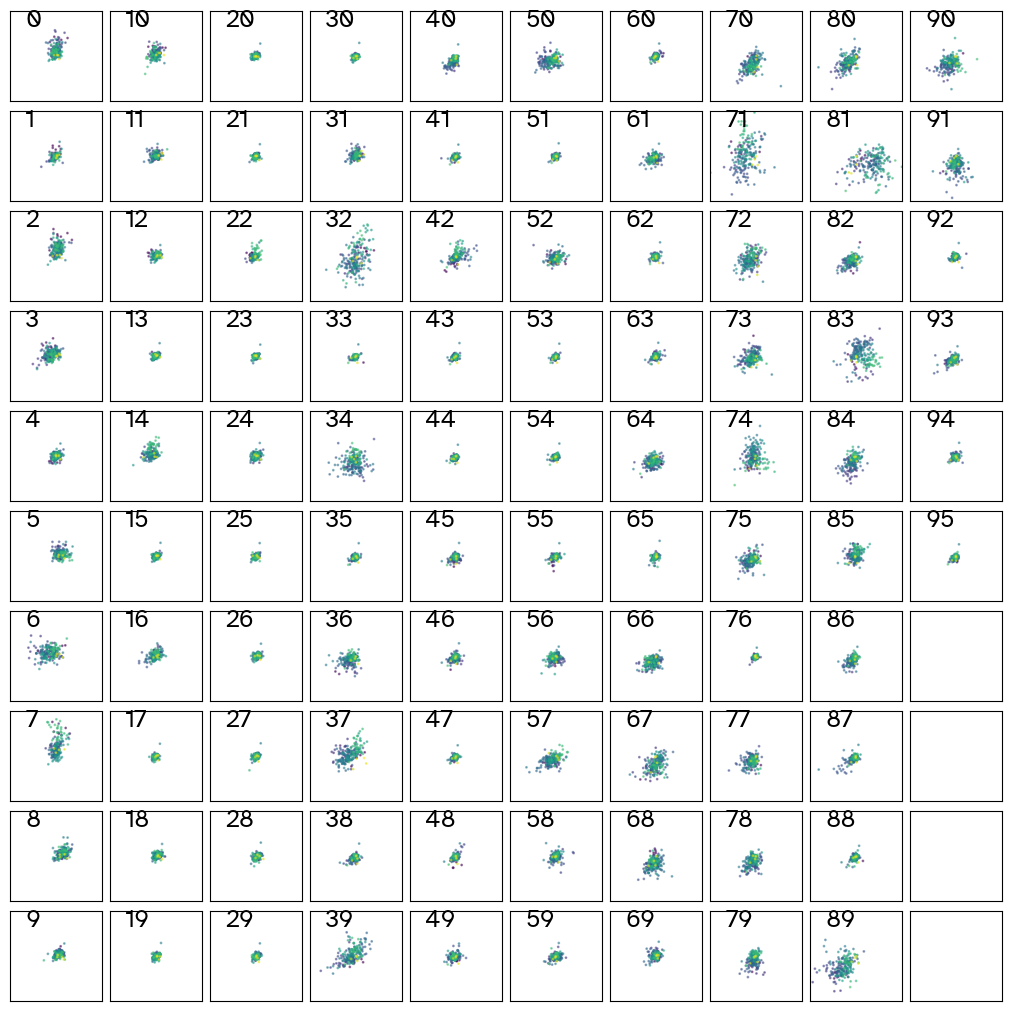

In [161]:
dd = pd.to_datetime(dates_used)
days = (dd - dd[0]).to_series().dt.days.to_numpy()
cts = np.stack(channel_tunings)

cts.shape

channel = 3
fig, ax = plt.subplots(10,10, sharex=True, sharey=True, layout='constrained', figsize=(10,10))
print(days.shape)
print(cts.shape)
for i in range(10):      
    for j in range(10):
        channel = i + j*10
        if channel < 96:
            sc = ax[i,j].scatter(cts[:,channel,0],cts[:,channel,1], s=1, c=days, marker='o', alpha=0.5)
            ax[i,j].annotate(channel, (-.2,.2))
            ax[i,j].set(ylim=(-.3,.3),xlim=(-.3,.3), xticks=[], yticks=[])

#single nueron positional 
# plt.colorbar(sc)

In [312]:
date_range =(days[0], days[-1])
time_range_num = 4
time_edges = np.linspace(date_range[0], date_range[1], num=time_range_num+1)

path_length_dict = {'channel':[],
                    'path_length':[],
                    'range_num':[]}

leg_labels = []
for i in range(time_range_num):
    path_lengths = np.zeros((96,1))
    range_start = time_edges[i]
    range_end = time_edges[i+1]
    leg_labels.append(f'{int(range_start)}-{int(range_end)}')
    cond1 = days >= range_start
    cond2 = days < range_end
    for j in range(96):
        lengths = np.sqrt(np.sum(np.diff(cts[cond1 & cond2,j,0:2], axis=0)**2, axis=1))
        
        path_length_dict['channel'].append(j)
        path_length_dict['path_length'].append(np.sum(lengths))
        path_length_dict['range_num'].append(i)

path_length_df = pd.DataFrame.from_dict(path_length_dict)

#drop nans for now
path_length_df.dropna(axis=0, inplace=True)

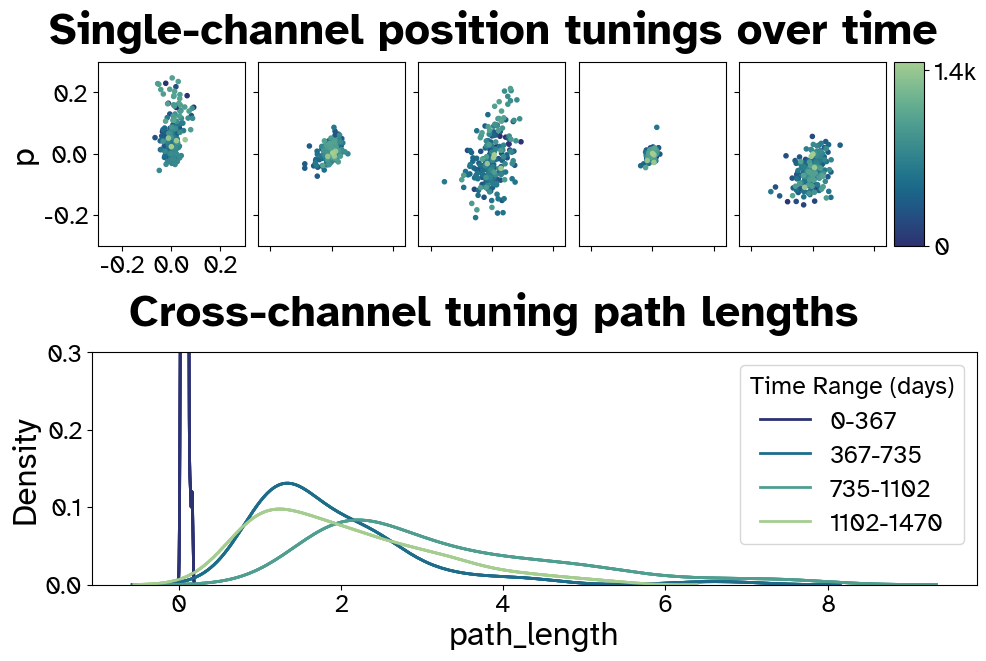

In [313]:
example_channels = [7, 16, 32, 51, 67]

figsize = (9.75, 6.5)
fig = plt.figure(figsize=figsize)
subfigs = fig.subfigures(2,1, height_ratios=(1.5, 2))
ex_ax = subfigs[0].subplots(1,6, width_ratios=(1,1,1,1,1,0.2))
subfigs[0].suptitle('Single-channel position tunings over time')
subfigs[1].suptitle('Cross-channel tuning path lengths')
pl_ax = subfigs[1].subplots(1,1)

orig_map = sns.color_palette('crest', as_cmap=True)

for i in range(5):
    channel = example_channels[i]
    # channel_df = pd.DataFrame(cts[:,channel,:], columns=('idx_pos','mrs_pos','idx_vel','mrs_vel'))
    # sns.scatterplot(channel_df, x='idx_pos', y='mrs_pos', hue=days, ax=ex_ax[i], legend=False)
    sc = ex_ax[i].scatter(cts[:,channel,0],cts[:,channel,1], c=days, marker='.', cmap=orig_map.reversed())
    
    if i == 0:
        ex_ax[i].set(ylim=(-.3,.3),xlim=(-.3,.3), xticks=[-.2,0,.2], yticks=[-.2,0,.2],ylabel='p')
    else:
        ex_ax[i].set(ylim=(-.3,.3),xlim=(-.3,.3), xticklabels=[], yticklabels=[])
cbar = fig.colorbar(sc, cax=ex_ax[5])
cbar.ax.set(yticks=[0,1400],yticklabels=['0','1.4k'])

for i in range(time_range_num):
    sns.kdeplot(path_length_df, x="path_length", hue="range_num", linewidth=2, ax=pl_ax, palette=orig_map)

pl_ax.legend(title='Time Range (days)', labels=leg_labels)
pl_ax.set(ylim=(0,0.3))

fig.savefig(os.path.join(config.characterizationdir,'singleneuraltuning.pdf'))

In [251]:
np.nonzero(np.isnan(path_lengths))

(array([], dtype=int64), array([], dtype=int64))

In [147]:

# print(np.unique(directions))

def calc_dir_coeff(row):
    trial_index = int(row['trial_index'])
    trial_count = int(row['trial_count'])
    trial_sbp = sbp[trial_index:(trial_index+trial_count),:]
    trial_behavior = kin[trial_index:(trial_index+trial_count),:]
    tuning = np.zeros((96, 4))
    for i in range(96):
        single_channel = trial_sbp[:,i]
        for j in range(4):
            single_kin = trial_behavior[:,j]
            tuning[i,j] = np.corrcoef(single_channel,single_kin)[0,1]
    tuning = np.mean(tuning, axis=1)
    return tuning


for date in dates:
    file = os.path.join(config.preprocessingdir,f'{date}_preprocess.pkl')

    with open(file, 'rb') as f:
        data_CO, data_RD = pickle.load(f)

    if data_CO:
        dates_used.append(date)
        sbp = data_CO['sbp']
        kin = data_CO['finger_kinematics']
        trials = data_CO['trial_index']
        trial_len = data_CO['trial_count']
        tpos = data_CO['target_positions']
    else:
        continue

    tpos = tpos - np.asarray([0.5, 0.5])
    directions = np.arctan2(tpos[:,0],tpos[:,1])
    trial_df = pd.DataFrame({'trial_index':trials, 'trial_count':trial_len, 'direction':directions})

    day_mean_tunings = []
    day_std_tunings = []
    day_dirs = []
    for direction, trials in trial_df.groupby('direction'):
        print(type(trials))   

        tuning = np.stack(trials.apply(calc_dir_coeff, axis=1))

        # for trial in trials.iterrows():
        #     pdb.set_trace()
        #     tuning = calc_dir_coeff(trial['trial_index'],trial['trial_count'])
        #     directional_tuning.append(tuning)
        
        # dt_arr = np.stack(tuning)
        day_dirs.append(direction)
        day_mean_tunings.append(np.mean(tuning,axis=0))
        day_std_tunings.append(np.std(tuning, axis=0))

    day_mean_tunings = np.stack(day_mean_tunings)
    day_std_tunings = np.stack(day_std_tunings)
    pdb.set_trace()

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
> c:\users\hisham\appdata\local\temp\ipykernel_26204\1393899967.py(18)<module>()



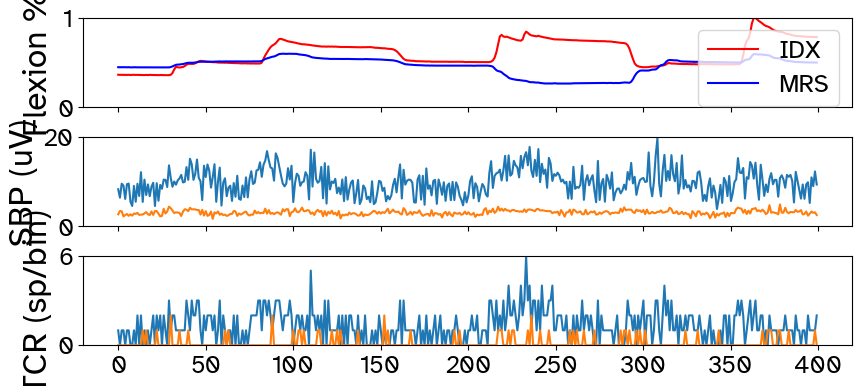

In [336]:
file = os.path.join(config.preprocessingdir,f'2022-04-15_preprocess.pkl')
with open(file, 'rb') as f:
    data_CO, data_RD = pickle.load(f)

sbp = data_CO['sbp']
tcr = data_CO['tcfr']
kin = data_CO['finger_kinematics']
tpos = data_CO['target_positions']

timerange = (100,500)

fig, ax = plt.subplots(3,1, sharex=True, figsize=(8.5, 3.75))

channel1 = 32
channel2 = 67

ax[1].plot(sbp[timerange[0]:timerange[1],channel1]*.25)
ax[1].plot(sbp[timerange[0]:timerange[1],channel2]*.25)
ax[1].set(ylim=(0,20), ylabel='SBP (uV)')

ax[2].plot(tcr[timerange[0]:timerange[1],channel1])
ax[2].plot(tcr[timerange[0]:timerange[1],channel2])
ax[2].set(ylim=(0,6),yticks=(0,6), ylabel='TCR (sp/bin)')

ax[0].plot(kin[timerange[0]:timerange[1],0], 'r', label='IDX')
ax[0].plot(kin[timerange[0]:timerange[1],1], 'b', label='MRS')
ax[0].set(ylim=(0,1), ylabel='Flexion %')

ax[0].legend()
fig.savefig(os.path.join(config.characterizationdir, "extraces.pdf"))